In [1]:
import pandas as pd
import numpy as np
import os
import sys
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pickle

In [2]:
# Reproducible results
random_state = 42
np.random.seed(random_state)

# Data

In [3]:
def get_data(one_hot_enc=True, reshape=False, train_val_test=False):
    DATA_PATH = "../data/"
    file_list = os.listdir(DATA_PATH)
    images_path = file_list[0]
    labels_path = file_list[1]
    images_path_full = os.path.join(DATA_PATH + images_path)
    labels_path_full = os.path.join(DATA_PATH + labels_path)
    X = pd.read_csv(images_path_full)
    if reshape:
        X = X.values.astype('float32')
        # Normalize data
        X = X / 255
        # Reshape for cnn 
        X = X.reshape([-1, 28, 28, 1]).astype('float32')
    else:
        # Normalize data
        X = X / 255
    y = pd.read_csv(labels_path_full)
    # Encode labels
    if one_hot_enc:
        encoder = OneHotEncoder(sparse=False, categories='auto')
        y = encoder.fit_transform(y)
    # Divide into train and test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    if train_val_test:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=random_state)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [4]:
def print_data_shapes_val(X_train, X_val, X_test, y_train, y_val, y_test):
    print("X_train_nn: ", X_train.shape)
    print("X_val_nn: ", X_val.shape)
    print("X_test_nn: ", X_test.shape)
    print("y_train_nn: ", y_train.shape)
    print("y_val_nn: ", y_val.shape)
    print("y_test_nn: ", y_test.shape)

In [5]:
def print_data_shapes_nval(X_train, X_test, y_train, y_test):
    print("X_train_nn: ", X_train.shape)
    print("X_test_nn: ", X_test.shape)
    print("y_train_nn: ", y_train.shape)
    print("y_test_nn: ", y_test.shape)

# Classifiers

In [6]:
classifiers_dict = {}

In [7]:
model_folder_path = "../models/"

### Feed Forward Neural Net

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras import regularizers
import keras

In [9]:
X_train_nn, X_val_nn, X_test_nn, y_train_nn, y_val_nn, y_test_nn = get_data(train_val_test=True)

In [10]:
model_name_nn = "MNIST_nn"
model_name_ext_nn = ".hdf5"
full_path_nn = model_folder_path + model_name_nn + model_name_ext_nn

In [ ]:
# Load the model
model_nn = keras.models.load_model(full_path_nn)

In [11]:
# Params

# Model compile
adam = Adam(lr=1e-3)
metrics = ['accuracy']
loss = 'categorical_crossentropy'

# Model architecture
regularizer_l2 = regularizers.l2(0.01)

# Model fit
epochs = 12
batch_size = 64

In [12]:
print_data_shapes_val(X_train_nn, X_val_nn, X_test_nn, y_train_nn, y_val_nn, y_test_nn)

X_train_nn:  (39199, 784)
X_val_nn:  (16800, 784)
X_test_nn:  (14000, 784)
y_train_nn:  (39199, 10)
y_val_nn:  (16800, 10)
y_test_nn:  (14000, 10)


In [13]:
model_nn = Sequential()
model_nn.add(Dense(256, input_dim=784, activation='relu', kernel_regularizer=regularizer_l2))
model_nn.add(Dense(128, activation='relu'))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(8, activation='relu', kernel_regularizer=regularizer_l2))
model_nn.add(Dense(10, activation='softmax'))

In [14]:
model_nn.compile(loss=loss, optimizer=adam, metrics=metrics)

In [15]:
start_nn = time.time()
history_nn = model_nn.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=epochs, batch_size=batch_size)
end_nn = time.time()
scores_nn = model_nn.evaluate(X_test_nn, y_test_nn)

Train on 39199 samples, validate on 16800 samples
Epoch 1/12
39199/39199 [==============================] - 6s 160us/step - loss: 1.0513 - acc: 0.8305 - val_loss: 0.5049 - val_acc: 0.9298
Epoch 2/12
39199/39199 [==============================] - 6s 148us/step - loss: 0.4660 - acc: 0.9308 - val_loss: 0.4564 - val_acc: 0.9242
Epoch 3/12
39199/39199 [==============================] - 6s 148us/step - loss: 0.3904 - acc: 0.9439 - val_loss: 0.4037 - val_acc: 0.9355
Epoch 4/12
39199/39199 [==============================] - 6s 149us/step - loss: 0.3471 - acc: 0.9494 - val_loss: 0.3405 - val_acc: 0.9521
Epoch 5/12
39199/39199 [==============================] - 6s 151us/step - loss: 0.3184 - acc: 0.9534 - val_loss: 0.3363 - val_acc: 0.9489
Epoch 6/12
39199/39199 [==============================] - 7s 182us/step - loss: 0.2880 - acc: 0.9583 - val_loss: 0.3093 - val_acc: 0.9520
Epoch 7/12
39199/39199 [==============================] - 8s 209us/step - loss: 0.2767 - acc: 0.9582 - val_loss: 0.2864 - 

In [16]:
tot_nn = round(end_nn - start_nn, 2)

In [17]:
print("Scores: ", scores_nn, "\n Training time: ", tot_nn, " seconds")

Scores:  [0.23473759935583388, 0.9642142857142857] 
 Training time:  94.46  seconds


> Can see that the model is somewhat overfitting - Will try to implement *Regularizer*
<br>
This resulted in a loss in accuracy, but there is a trade off between accuracy and overfitting

In [18]:
classifiers_dict['(Standard) Neural Network'] = {'accuracy': scores_nn[1], 'time': tot_nn}

In [21]:
keras.models.save_model(model_nn, full_path_nn)

### CNN

In [32]:
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.datasets import mnist
from keras.utils import np_utils

In [33]:
X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn = get_data(one_hot_enc=False, reshape=True, train_val_test=True)

In [34]:
y_train_cnn = np_utils.to_categorical(y_train_cnn)
y_val_cnn = np_utils.to_categorical(y_val_cnn)
y_test_cnn = np_utils.to_categorical(y_test_cnn)

In [35]:
print_data_shapes_val(X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn)

X_train_nn:  (39199, 28, 28, 1)
X_val_nn:  (16800, 28, 28, 1)
X_test_nn:  (14000, 28, 28, 1)
y_train_nn:  (39199, 10)
y_val_nn:  (16800, 10)
y_test_nn:  (14000, 10)


In [36]:
model_name_cnn = "MNIST_cnn"
model_name_ext_cnn = ".hdf5"
full_path_cnn = model_folder_path + model_name_cnn + model_name_ext_cnn

In [45]:
# Load the model
model_cnn = keras.models.load_model(full_path_cnn)

In [37]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.4))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))

In [38]:
model_cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [39]:
start_cnn = time.time()
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=4, batch_size=200)
end_cnn = time.time()
scores_cnn = model_cnn.evaluate(X_test_cnn, y_test_cnn)

Train on 39199 samples, validate on 16800 samples
Epoch 1/4
39199/39199 [==============================] - 20s 515us/step - loss: 0.1929 - acc: 0.9382 - val_loss: 0.0729 - val_acc: 0.9785
Epoch 2/4
39199/39199 [==============================] - 21s 543us/step - loss: 0.0611 - acc: 0.9799 - val_loss: 0.0652 - val_acc: 0.9789
Epoch 3/4
39199/39199 [==============================] - 25s 642us/step - loss: 0.0438 - acc: 0.9863 - val_loss: 0.0514 - val_acc: 0.9842
Epoch 4/4
14000/14000 [==============================] - 4s 306us/step


In [44]:
tot_cnn = round(end_cnn - start_cnn, 2)

In [41]:
print("Scores: ", scores_cnn, "\n Training time: ", tot_cnn, " seconds")

Scores:  [0.04565956243426938, 0.9862142857142857] 
 Training time:  90.88  seconds


In [42]:
classifiers_dict['Convolutional Neural Network'] = {'accuracy': scores_cnn[1], 'time': tot_cnn}

In [43]:
# Save the model
keras.models.save_model(model_cnn, full_path_cnn)

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [28]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = get_data()

In [29]:
print_data_shapes_nval(X_train_rf, X_test_rf, y_train_rf, y_test_rf)

X_train_nn:  (55999, 784)
X_test_nn:  (14000, 784)
y_train_nn:  (55999, 10)
y_test_nn:  (14000, 10)


In [78]:
model_name_rf = "MNIST_Random_Forest"
model_name_ext_rf = ".pickle.dat"
full_path_rf = model_folder_path + model_name_rf + model_name_ext_rf

In [ ]:
# Load model
# random_f_clf = pickle.load(open(full_path_rf), "rb")

In [ ]:
random_f_clf = RandomForestClassifier(n_estimators=50,
                                     n_jobs = 2,
                                     random_state=random_state)
start_rf = time.time()
random_f_clf.fit(X_train_rf, y_train_rf)
end_rf = time.time()

In [ ]:
tot_rf = round(end_rf - start_rf, 2)

In [ ]:
y_pred_rf = random_f_clf.predict(X_test_rf)
scores_rf = accuracy_score(y_test_rf, y_pred_rf)

In [32]:
print("Scores: ", scores_rf, "\n Training time: ", tot_rf, " seconds")

Scores:  0.8957857142857143 
 Training time:  14.08  seconds


In [33]:
classifiers_dict['Random Forest'] = {'accuracy': scores_rf, 'time': tot_rf}

In [79]:
# Save the model
pickle.dump(random_f_clf, open(full_path_rf, "wb"))

### XGBoost

In [34]:
# If needing to install xgboost (using conda)
# ! conda install py-xgboost

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [36]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = get_data(one_hot_enc=False)

In [37]:
print_data_shapes_nval(X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)

X_train_nn:  (55999, 784)
X_test_nn:  (14000, 784)
y_train_nn:  (55999, 1)
y_test_nn:  (14000, 1)


In [80]:
model_name_xgb = "MNIST_XGBoost"
model_name_ext_xgb = ".pickle.dat"
full_path_xgb = model_folder_path + model_name_xgb + model_name_ext_xgb

### NOTE: If you want to save time - load the model. 

In [ ]:
# Load the model
# optim_est_xgb = pickle.load(open(full_path_xgb), "rb")

In [ ]:
params = {
        'gamma': [0.5, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 5],
        'n_estimators': [5, 10]
        }

Fun to try with more parameters, but my poor CPU cannot take any more..

## Disclaimer: This takes a lot of time

In [ ]:
%%capture 
xgb_clf = XGBClassifier()
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=2,
                  scoring="accuracy",
                  n_jobs=1,
                  verbose=2)
start_xgb = time.time()
rs.fit(X_train_xgb, y_train_xgb.values.ravel())
end_xgb = time.time()

In [ ]:
optim_est_xgb = rs.best_estimator_
print(optim_est_xgb)

In [ ]:
tot_xgb = round(end_xgb - start_xgb, 2)

In [42]:
y_pred_xgb = optim_est_xgb.predict(X_test_xgb)
scores_xgb = accuracy_score(y_test_xgb, y_pred_xgb)

In [43]:
print("Scores: ", scores_xgb, "\n Training time: ", tot_xgb, " seconds")

Scores:  0.9046428571428572 
 Training time:  2467.44  seconds


In [44]:
classifiers_dict['XGBoost'] = {'accuracy': scores_xgb, 'time': tot_xgb}

In [81]:
pickle.dump(optim_est_xgb, open(full_path_xgb, "wb"))

## Evaluating

In [45]:
for k, v in classifiers_dict.items():
    print(k, v)

(Standard) Neural Network {'accuracy': 0.9585714285714285, 'time': 67.99}
Convolutional Neural Network {'accuracy': 0.9859285714285714, 'time': 86.85}
Random Forest {'accuracy': 0.8957857142857143, 'time': 14.08}
XGBoost {'accuracy': 0.9046428571428572, 'time': 2467.44}


TypeError: unsupported operand type(s) for +: 'int' and 'dict'

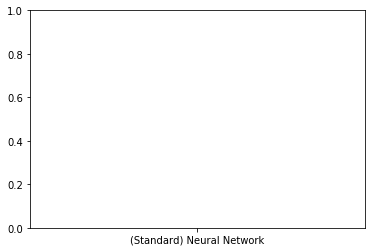

In [46]:
plt.bar(list(classifiers_dict.keys()), classifiers_dict.values(), color='g')